In [216]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
===================================================================================================
Modelo No Supervisado para Análisis de Datos de Transporte
===================================================================================================

Este script carga un dataset en formato JSON  que contiene
información de rutas históricas y estaciones. Se realiza el preprocesamiento de los datos,
se extraen variables relevantes, se aplica el clustering mediante K-Means y se evalúa 
la calidad del clustering mediante la puntuación silhouette. Además, se reduce la dimensionalidad
con PCA para visualizar los clusters.

El script está estructurado en las siguiente secciones:
    1. Importación de librerías y configuración global
    2. Funciones para carga y preprocesamiento de datos
    3. Funciones de ingeniería de características
    4. Funciones de análisis de clustering y evaluación
    5. Funciones de visualización
    6. Función principal (main)
    7. Ejecución del script
    8. Sección Extra: Funciones de Utilidad y Ejemplos Adicionales


===================================================================================================
"""

# ==============================================================================================
# 1. Importación de Librerías y Configuración Global
# ==============================================================================================
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import logging
from datetime import datetime
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import os
import sys
import pickle

# Mensajes informativos
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s - %(levelname)s - %(message)s')


In [217]:
# ==============================================================================================
# 2. Funciones para Carga y Preprocesamiento de Datos
# ==============================================================================================

def load_json_data(filepath):
    """
    Carga el archivo JSON y retorna los datos.
    """
    logging.info("Cargando datos del archivo JSON: %s", filepath)
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            data = json.load(f)
        logging.info("Carga de datos completada.")
        return data
    except Exception as e:
        logging.error("Error al cargar el archivo: %s", e)
        sys.exit(1)

def preprocess_rutas(data):
    """
    Extrae y preprocesa la sección 'rutas_historicas' del dataset.

    """
    logging.info("Extrayendo rutas históricas del dataset.")
    rutas = data.get('rutas_historicas', [])
    if not rutas:
        logging.warning("No se encontraron rutas en los datos.")
    
    lista_rutas = []
    for ruta in rutas:
        # Extraer métricas y valores de la ruta
        metricas = ruta.get('metricas', {})
        ruta_dict = {
            'fecha': ruta.get('fecha', None),
            'hora': ruta.get('hora', None),
            'origen': ruta.get('origen', None),
            'destino': ruta.get('destino', None),
            'tiempo_esperado': ruta.get('tiempo_esperado', np.nan),
            'tiempo_real': ruta.get('tiempo_real', np.nan),
            'costo': ruta.get('costo', np.nan),
            'distancia_km': ruta.get('distancia_km', np.nan),
            'ocupacion_porcentaje': metricas.get('ocupacion_porcentaje', np.nan),
            'satisfaccion_usuario': metricas.get('satisfaccion_usuario', np.nan),
            'retraso': metricas.get('retraso', np.nan)
        }
        lista_rutas.append(ruta_dict)
    
    df = pd.DataFrame(lista_rutas)
    logging.info("Se extrajeron %d registros de rutas.", len(df))
    return df

def clean_data(df):
    """
    Realiza la limpieza de datos eliminando registros con valores nulos.
    
    """
    initial_count = df.shape[0]
    df_clean = df.dropna().reset_index(drop=True)
    final_count = df_clean.shape[0]
    eliminados = initial_count - final_count
    logging.info("Limpieza de datos: se eliminaron %d registros con datos faltantes.", eliminados)
    return df_clean

# ==============================================================================================
# 
# ==============================================================================================

# Definir la ruta del dataset
dataset_path = 'dataset_transporte_enriquecido.json'

# Cargar datos
data = load_json_data(dataset_path)
print('Carga de datos completa')

# Preprocesar rutas
df_rutas = preprocess_rutas(data)
print("Preview de los datos extraídos")
display(df_rutas.head())  

# Limpieza de datos
df_rutas_limpio = clean_data(df_rutas)
print("Cantidad de registros eliminados durante la limpieza:", len(df_rutas) - len(df_rutas_limpio))


2025-04-13 12:45:14,247 - INFO - Cargando datos del archivo JSON: dataset_transporte_enriquecido.json
2025-04-13 12:45:14,264 - INFO - Carga de datos completada.
2025-04-13 12:45:14,265 - INFO - Extrayendo rutas históricas del dataset.
2025-04-13 12:45:14,273 - INFO - Se extrajeron 3600 registros de rutas.


Carga de datos completa
Preview de los datos extraídos


,fecha,hora,origen,destino,tiempo_esperado,tiempo_real,costo,distancia_km,ocupacion_porcentaje,satisfaccion_usuario,retraso
0,2025-01-01,0,A,B,10,16.28,2.5,5.2,13,77,6.28
1,2025-01-01,0,B,C,15,23.31,3.0,7.8,22,85,8.31
2,2025-01-01,0,C,D,20,28.72,2.0,10.5,36,79,8.72
3,2025-01-01,0,A,E,15,24.73,4.0,8.3,24,84,9.73
4,2025-01-01,0,E,D,28,45.62,4.0,12.1,35,90,17.62


2025-04-13 12:45:14,282 - INFO - Limpieza de datos: se eliminaron 0 registros con datos faltantes.


Cantidad de registros eliminados durante la limpieza: 0


In [218]:
# ==============================================================================================
# 3. Funciones de Ingeniería
# ==============================================================================================

def convert_fecha_to_datetime(df, fecha_column='fecha'):
    """
    Convierte la columna de fechas a tipo datetime.
    """
    logging.info("Convirtiendo la columna '%s' a datetime.", fecha_column)
    df[fecha_column] = pd.to_datetime(df[fecha_column], format='%Y-%m-%d', errors='coerce')
    return df

def add_time_features(df):
    """
    Agrega características adicionales a partir de la columna 'fecha' y 'hora'.
    """
    logging.info("Agregando características temporales a los datos.")
    if 'fecha' in df.columns:
        df = convert_fecha_to_datetime(df, 'fecha')
        df['mes'] = df['fecha'].dt.month
        df['dia'] = df['fecha'].dt.day
    if 'hora' in df.columns:
        df['hora'] = pd.to_numeric(df['hora'], errors='coerce')
    return df

def select_features(df):
    """
    Selecciona las características numéricas relevantes para el clustering.
    """
    logging.info("Seleccionando características para el modelo.")
    features = [
        'tiempo_esperado',
        'tiempo_real',
        'costo',
        'distancia_km',
        'ocupacion_porcentaje',
        'satisfaccion_usuario',
        'retraso'
    ]
    if 'mes' in df.columns:
        features.append('mes')
    if 'hora' in df.columns:
        features.append('hora')

    df_features = df[features].copy()
    logging.info("Características seleccionadas: %s", features)
    return df_features, features

def scale_features(df):
    """
    Escala las características numéricas usando StandardScaler.
    """
    logging.info("Escalando las características numéricas.")
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df)
    return X_scaled, scaler

# ------------------------------------------------------------------------------------------------
# Ejecución fuera de funciones (para el bloque de Jupyter)
# ------------------------------------------------------------------------------------------------
# Convertir data en DataFrame
df = pd.DataFrame([data]).copy()
print("Columnas originales:", df.columns.tolist())
print("Vista previa del DataFrame:")
print(df.head())

# Agregar características de tiempo
df = add_time_features(df)
print("Columnas tras agregar features:", df.columns.tolist())


2025-04-13 12:45:14,312 - INFO - Agregando características temporales a los datos.


Columnas originales: ['metadata', 'estaciones', 'rutas_historicas', 'reglas']
Vista previa del DataFrame:
                                            metadata  \
0  {'fecha_generacion': '2025-04-12 21:31:32', 'p...   

                                          estaciones  \
0  [{'id': 'A', 'nombre': 'Estación Central', 'la...   

                                    rutas_historicas  \
0  [{'fecha': '2025-01-01', 'hora': 0, 'origen': ...   

                                              reglas  
0  [{'condicion': 'hora_punta', 'prioridad': 'men...  
Columnas tras agregar features: ['metadata', 'estaciones', 'rutas_historicas', 'reglas']


In [ ]:
# ==============================================================================================
# 4. Funciones de Análisis de Clustering y Evaluación
# ==============================================================================================

def compute_kmeans(X, num_clusters=3, random_state=42):
    """
    Aplica K-Means al conjunto de datos.
    
    """
    logging.info("Aplicando K-Means con %d clusters.", num_clusters)
    kmeans = KMeans(n_clusters=num_clusters, random_state=random_state, n_init=10)
    clusters = kmeans.fit_predict(X)
    logging.info("Clustering completado.")
    return clusters, kmeans


def evaluate_clustering(X, labels):
    """
    Evalúa la calidad del clustering usando la puntuación silhouette.
    
    """
    logging.info("Evaluando la calidad del clustering.")
    try:
        score = silhouette_score(X, labels)
        logging.info("La puntuación silhouette es: %.4f", score)
        return score
    except Exception as e:
        logging.error("Error al calcular el silhouette score: %s", e)
        return None

# Agregar características temporales
df_rutas_feat = add_time_features(df_rutas_limpio)
print("Características temporales agregadas (columnas 'mes', 'dia' y 'hora'):")
display(df_rutas_feat[['fecha', 'hora', 'mes', 'dia']].head())






2025-04-13 12:45:14,319 - INFO - Agregando características temporales a los datos.
2025-04-13 12:45:14,320 - INFO - Convirtiendo la columna 'fecha' a datetime.


Características temporales agregadas (columnas 'mes', 'dia' y 'hora'):


,fecha,hora,mes,dia
0,2025-01-01,0,1,1
1,2025-01-01,0,1,1
2,2025-01-01,0,1,1
3,2025-01-01,0,1,1
4,2025-01-01,0,1,1


2025-04-13 12:45:14,336 - INFO - Aplicando PCA para reducción de dimensionalidad.
2025-04-13 12:45:14,337 - INFO - PCA completado. Varianza explicada por componente: [0.43270393 0.22105893]


Reducción de dimensionalidad con PCA completada.
Varianza explicada por componente: [0.43270393 0.22105893]


,PC1,PC2
0,-2.448788,0.155970
1,-1.157094,-0.917912
2,-0.030511,-0.431324
3,-0.616217,-1.102955
4,2.300397,-2.209383


2025-04-13 12:45:14,348 - INFO - Generando gráfica de clusters.


Clustering con KMeans completado. Número de clusters: 3


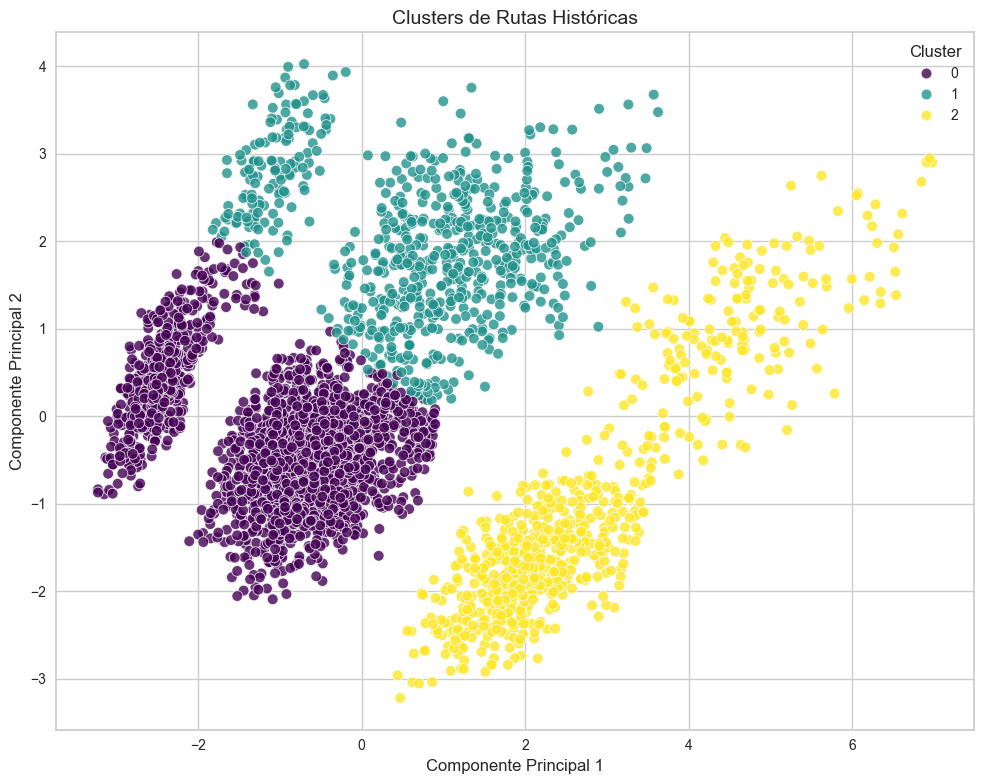

2025-04-13 12:45:14,598 - INFO - Generando gráficas de distribuciones por cluster.


AttributeError: 'tuple' object has no attribute 'copy'

In [ ]:
# ==============================================================================================
# 5. Funciones de Visualización
# ==============================================================================================

def reduce_dimensionality(X, n_components=2):
    """
    Reduce la dimensionalidad de los datos con PCA para visualización.
    
    """
    logging.info("Aplicando PCA para reducción de dimensionalidad.")
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)
    logging.info("PCA completado. Varianza explicada por componente: %s", pca.explained_variance_ratio_)
    return X_pca, pca


def plot_clusters(X_pca, labels, title='Clusters de Rutas Históricas'):
    """
    Grafica los clusters obtenidos en un plano 2D.

    """
    logging.info("Generando gráfica de clusters.")
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels, palette='viridis', s=60, alpha=0.8)
    plt.title(title, fontsize=14)
    plt.xlabel('Componente Principal 1', fontsize=12)
    plt.ylabel('Componente Principal 2', fontsize=12)
    plt.legend(title="Cluster")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_feature_distributions(df, cluster_labels):
    """
    Grafica las distribuciones de las características principales para cada cluster.
    
    """
    logging.info("Generando gráficas de distribuciones por cluster.")
    df_viz = df.copy()
    df_viz['cluster'] = cluster_labels
    features = df_viz.columns.drop('cluster')
    num_features = len(features)
    
    # Crear figura con subplots
    fig, axes = plt.subplots(nrows=num_features, ncols=1, figsize=(10, 4 * num_features))
    if num_features == 1:
        axes = [axes]
    
    for i, feature in enumerate(features):
        sns.boxplot(x='cluster', y=feature, data=df_viz, ax=axes[i], palette='viridis')
        axes[i].set_title(f'Distribución de {feature} por cluster')
        axes[i].grid(True)
    
    plt.tight_layout()
    plt.show()

# ==============================================================================================
# Función para Cargar Rutas y Estaciones
# ==============================================================================================
def cargar_datos(archivo_json):
    """
    Carga los datos del dataset enriquecido desde un archivo JSON.
    
    """
    logging.info("Cargando datos usando la función cargar_datos desde: %s", archivo_json)
    with open(archivo_json, 'r', encoding='utf-8') as f:
        datos = json.load(f)
    
    # Convertir las rutas históricas y estaciones a DataFrames
    df_rutas = pd.DataFrame(datos.get('rutas_historicas', []))
    df_estaciones = pd.DataFrame(datos.get('estaciones', []))
    
    logging.info("Datos cargados: %d rutas y %d estaciones.", len(df_rutas), len(df_estaciones))
    return df_rutas, df_estaciones


# Ahora puedes ejecutar el resto del código
# 1. Reducir dimensionalidad con PCA
X_pca, pca = reduce_dimensionality(X_scaled)
print("Reducción de dimensionalidad con PCA completada.")
print("Varianza explicada por componente:", pca.explained_variance_ratio_)
display(pd.DataFrame(X_pca, columns=["PC1", "PC2"]).head())

# 2. Agrupar con KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(X_scaled)
print("Clustering con KMeans completado. Número de clusters:", kmeans.n_clusters)

# 3. Visualizar clusters en 2D
plot_clusters(X_pca, labels)

# 4. Ver distribución de características por cluster
plot_feature_distributions(df_features, labels)


In [ ]:
# ==============================================================================================
# 6. Función Principal (main)
# ==============================================================================================
def main():
    """
    Función principal que ejecuta todo el análisis:
        1. Carga de datos.
        2. Preprocesamiento y limpieza.
        3. Ingeniería de características.
        4. Escalado de características.
        5. Aplicación de clustering (K-Means).
        6. Evaluación del clustering.
        7. Reducción de dimensionalidad para visualización.
        8. Generación de gráficas.

    """
    # ------------------------------------------------------------------------------------------
    # 6.1. Configuración de la ruta del dataset
    # ------------------------------------------------------------------------------------------
    dataset_path = 'dataset_transporte_enriquecido.json'
    if not os.path.exists(dataset_path):
        logging.error("El archivo %s no se encontró.", dataset_path)
        sys.exit(1)
    
    # ------------------------------------------------------------------------------------------
    # 6.2. Carga de datos
 
    data = load_json_data(dataset_path)
    
  
    
    # ------------------------------------------------------------------------------------------
    # 6.3. Preprocesamiento de rutas
   
    df_rutas = preprocess_rutas(data)
    df_rutas = clean_data(df_rutas)
    df_rutas = add_time_features(df_rutas)
    
    # ------------------------------------------------------------------------------------------
    # 6.4. Selección y escalado de características
    df_features = select_features(df_rutas)
    X_scaled, scaler = scale_features(df_features)
    
    # ------------------------------------------------------------------------------------------
    # 6.5. Aplicación de clustering: K-Means
    num_clusters = 5  
    clusters, kmeans_model = compute_kmeans(X_scaled, num_clusters=num_clusters)
    df_rutas['cluster'] = clusters
    
    # ------------------------------------------------------------------------------------------
    # 6.6. Evaluación del clustering
    score = evaluate_clustering(X_scaled, clusters)
    if score is not None:
        logging.info("Silhouette Score: %.4f", score)
    
    # ------------------------------------------------------------------------------------------
    # 6.7. Reducción de dimensionalidad con PCA para visualización
    X_pca, pca_model = reduce_dimensionality(X_scaled, n_components=2)
    
    # ------------------------------------------------------------------------------------------
    # 6.8. Visualización de clusters
    plot_clusters(X_pca, clusters, title='Clusters de Rutas Históricas (PCA)')
    plot_feature_distributions(df_features, clusters)
    
    # ------------------------------------------------------------------------------------------
    # 6.9. Guardar resultados (opcional)
    output_csv = "rutas_clusterizadas.csv"
    df_rutas.to_csv(output_csv, index=False, encoding='utf-8')
    logging.info("Se han guardado los resultados en %s", output_csv)
    
    # ------------------------------------------------------------------------------------------
    # 6.10. Fin del procesamiento
    logging.info("Análisis completado exitosamente.")

    



2025-04-13 12:00:15,573 - INFO - Cargando datos del archivo JSON: dataset_transporte_enriquecido.json
2025-04-13 12:00:15,585 - INFO - Carga de datos completada.
2025-04-13 12:00:15,585 - INFO - Extrayendo rutas históricas del dataset.
2025-04-13 12:00:15,593 - INFO - Se extrajeron 3600 registros de rutas.
2025-04-13 12:00:15,594 - INFO - Limpieza de datos: se eliminaron 0 registros con datos faltantes.
2025-04-13 12:00:15,594 - INFO - Agregando características temporales a los datos.
2025-04-13 12:00:15,595 - INFO - Convirtiendo la columna 'fecha' a datetime.
2025-04-13 12:00:15,597 - INFO - Seleccionando características para el modelo.
2025-04-13 12:00:15,598 - INFO - Características seleccionadas: ['tiempo_esperado', 'tiempo_real', 'costo', 'distancia_km', 'ocupacion_porcentaje', 'satisfaccion_usuario', 'retraso', 'mes', 'hora']
2025-04-13 12:00:15,598 - INFO - Escalando las características numéricas.
2025-04-13 12:00:15,601 - INFO - Aplicando K-Means con 4 clusters.
2025-04-13 12:0

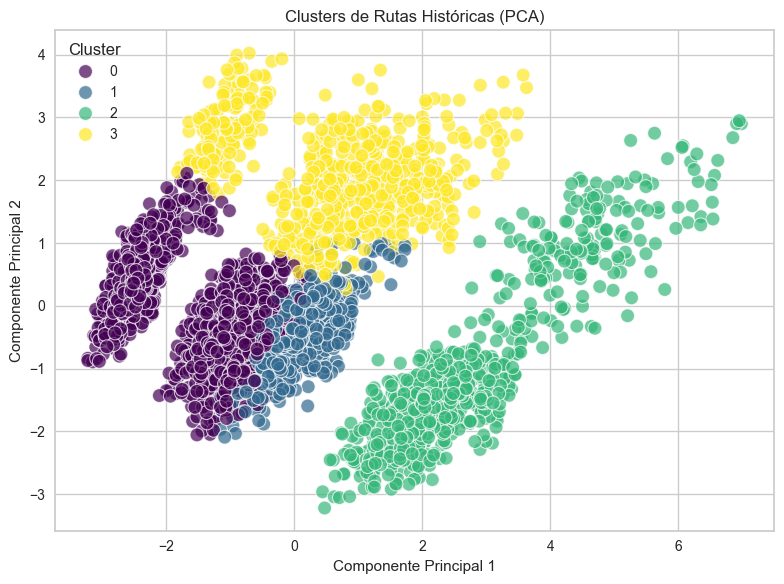

2025-04-13 12:00:15,943 - INFO - Visualización de clusters generada.
2025-04-13 12:00:15,944 - INFO - Generando gráficas de distribuciones por cluster.
2025-04-13 12:00:15,979 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-04-13 12:00:15,984 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-04-13 12:00:16,014 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-04-13 12:00:16,018 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to

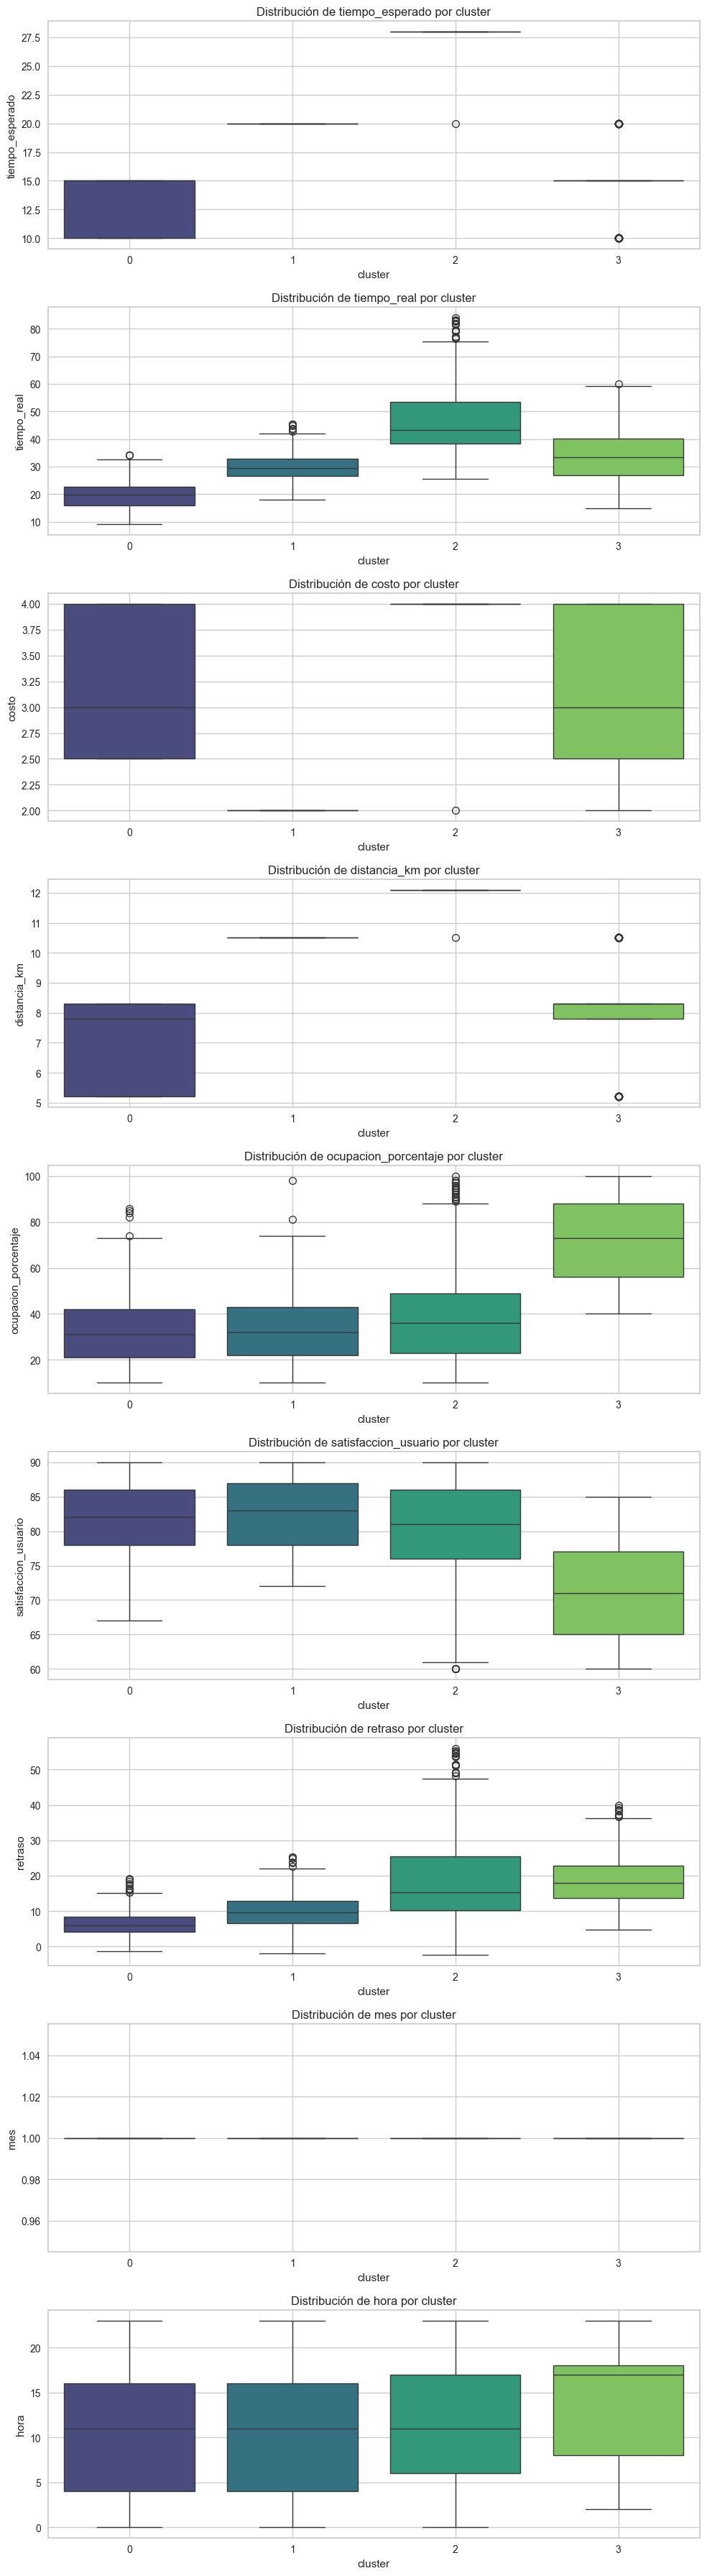

2025-04-13 12:00:16,670 - INFO - Se han guardado los resultados en rutas_clusterizadas.csv
2025-04-13 12:00:16,670 - INFO - Análisis completado exitosamente.
2025-04-13 12:00:16,672 - INFO - Ejecutando utilidades adicionales...
2025-04-13 12:00:16,672 - INFO - Cargando datos del archivo JSON: dataset_transporte_enriquecido.json
2025-04-13 12:00:16,685 - INFO - Carga de datos completada.
2025-04-13 12:00:16,686 - INFO - Extrayendo rutas históricas del dataset.
2025-04-13 12:00:16,693 - INFO - Se extrajeron 3600 registros de rutas.
2025-04-13 12:00:16,694 - INFO - Limpieza de datos: se eliminaron 0 registros con datos faltantes.
2025-04-13 12:00:16,694 - INFO - Agregando características temporales a los datos.
2025-04-13 12:00:16,695 - INFO - Convirtiendo la columna 'fecha' a datetime.
2025-04-13 12:00:16,697 - INFO - Seleccionando características para el modelo.
2025-04-13 12:00:16,698 - INFO - Características seleccionadas: ['tiempo_esperado', 'tiempo_real', 'costo', 'distancia_km', 'o

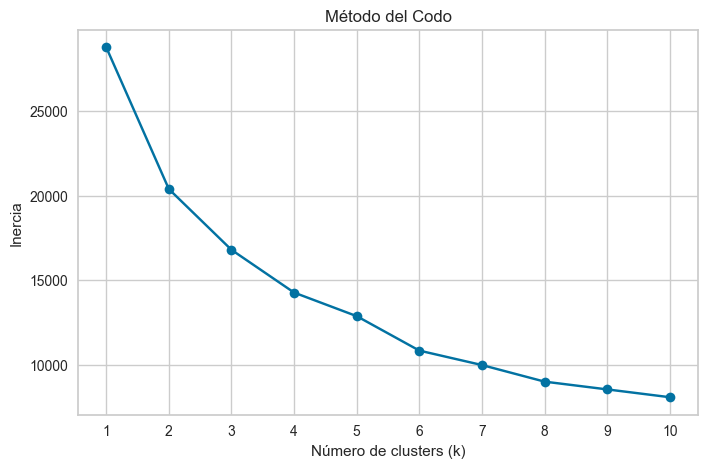

2025-04-13 12:00:16,804 - INFO - Gráfica del método del codo generada.
2025-04-13 12:00:16,958 - INFO - k=2: Silhouette Score = 0.3071
2025-04-13 12:00:17,099 - INFO - k=3: Silhouette Score = 0.2996
2025-04-13 12:00:17,237 - INFO - k=4: Silhouette Score = 0.2705
2025-04-13 12:00:17,371 - INFO - k=5: Silhouette Score = 0.2390
2025-04-13 12:00:17,511 - INFO - k=6: Silhouette Score = 0.2663
2025-04-13 12:00:17,645 - INFO - k=7: Silhouette Score = 0.2747
2025-04-13 12:00:17,780 - INFO - k=8: Silhouette Score = 0.2782
2025-04-13 12:00:17,912 - INFO - k=9: Silhouette Score = 0.2620
2025-04-13 12:00:18,049 - INFO - k=10: Silhouette Score = 0.2578


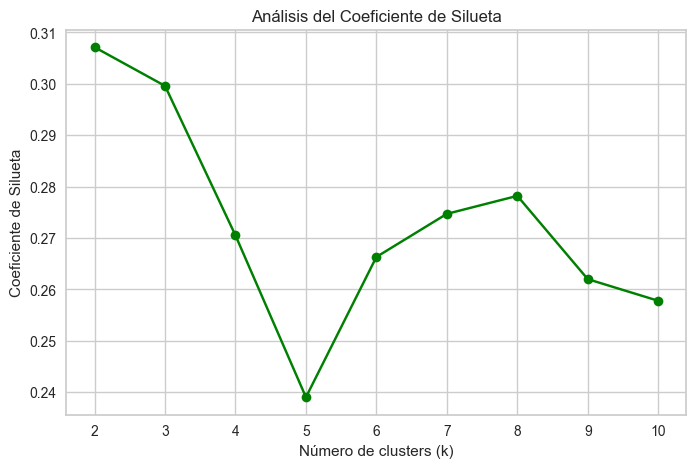

2025-04-13 12:00:18,109 - INFO - Gráfica del coeficiente de silueta generada.
2025-04-13 12:00:18,109 - INFO - Aplicando K-Means con 4 clusters.
2025-04-13 12:00:18,141 - INFO - Clustering completado.
2025-04-13 12:00:18,142 - INFO - Datos reducidos a 2 dimensiones.


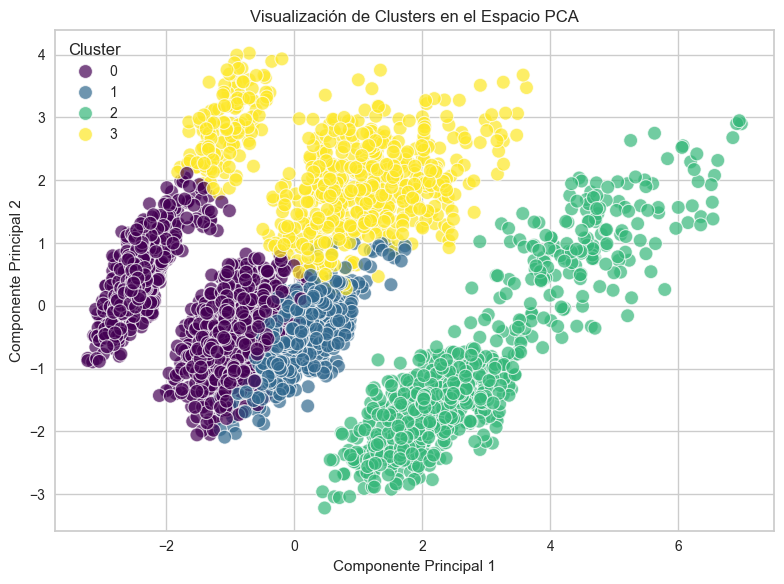

2025-04-13 12:00:18,339 - INFO - Visualización de clusters generada.
2025-04-13 12:00:18,341 - INFO - Modelo guardado en: modelos\kmeans_model.pkl
2025-04-13 12:00:18,341 - INFO - Modelo guardado en: modelos\scaler.pkl
2025-04-13 12:00:18,342 - INFO - Modelo guardado en: modelos\pca_model.pkl
2025-04-13 12:00:18,342 - INFO - Iniciando análisis exploratorio adicional.
2025-04-13 12:00:18,343 - INFO - Estadísticos descriptivos de los datos:


       tiempo_esperado  tiempo_real        costo  distancia_km  \
count      3600.000000  3600.000000  3600.000000   3600.000000   
mean         17.600000    29.116758     3.100000      8.780000   
std           6.086895    12.742498     0.800111      2.366253   
min          10.000000     9.000000     2.000000      5.200000   
25%          15.000000    20.000000     2.500000      7.800000   
50%          15.000000    26.390000     3.000000      8.300000   
75%          20.000000    36.337500     4.000000     10.500000   
max          28.000000    84.030000     4.000000     12.100000   

       ocupacion_porcentaje  satisfaccion_usuario      retraso     mes  \
count           3600.000000           3600.000000  3600.000000  3600.0   
mean              40.199722             79.915000    11.516758     1.0   
std               21.863805              7.163901     8.770835     0.0   
min               10.000000             60.000000    -2.440000     1.0   
25%               24.000000        

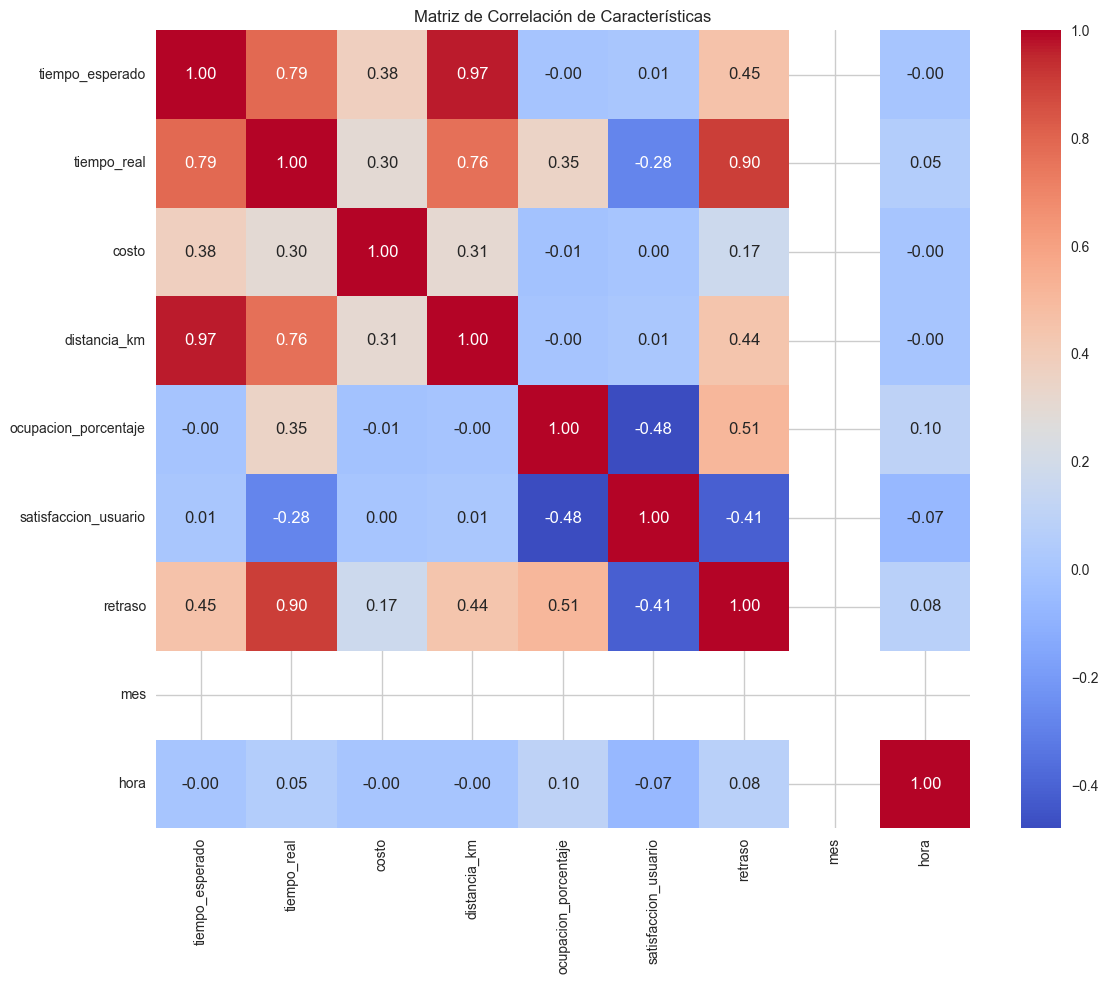

In [ ]:

# Función existente: additional_analysis
def additional_analysis(df):
    """
    Realiza un análisis exploratorio adicional incluyendo estadísticos descriptivos y
    una gráfica de correlaciones.
    """
    logging.info("Iniciando análisis exploratorio adicional.")
    
    # Estadísticos descriptivos
    logging.info("Estadísticos descriptivos de los datos:")
    print(df.describe())
    
    # Gráfica de correlaciones
    plt.figure(figsize=(12, 10))
    corr_matrix = df.corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Matriz de Correlación de Características")
    plt.tight_layout()
    plt.show()

# Función para guardar modelos en archivos pickle
def save_model(kmeans_model, scaler, pca_model, output_dir="modelos"):
    """
    Guarda los modelos entrenados en archivos pickle para usos futuros.
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    model_files = {
        'kmeans_model.pkl': kmeans_model,
        'scaler.pkl': scaler,
        'pca_model.pkl': pca_model
    }
    
    for filename, model in model_files.items():
        filepath = os.path.join(output_dir, filename)
        with open(filepath, 'wb') as f:
            pickle.dump(model, f)
        logging.info("Modelo guardado en: %s", filepath)

# Función para cargar un modelo guardado
def load_model(model_path):
    """
    Carga un modelo guardado desde un archivo pickle.
    """
    if not os.path.exists(model_path):
        logging.error("El archivo del modelo %s no existe.", model_path)
        return None
    with open(model_path, 'rb') as f:
        model = pickle.load(f)
    logging.info("Modelo cargado desde: %s", model_path)
    return model

# Función para calcular el método del codo
def plot_elbow_method(X, max_k=10):
    """
    Calcula y muestra la gráfica del método del codo para determinar el número óptimo de clusters.
    
    """
    inertia = []
    k_range = range(1, max_k+1)
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X)
        inertia.append(kmeans.inertia_)
    
    plt.figure(figsize=(8, 5))
    plt.plot(k_range, inertia, marker='o')
    plt.xlabel("Número de clusters (k)")
    plt.ylabel("Inercia")
    plt.title("Método del Codo")
    plt.xticks(k_range)
    plt.grid(True)
    plt.show()
    logging.info("Gráfica del método del codo generada.")

# Función para realizar análisis de la silueta
def silhouette_analysis(X, k_range):
    """
    Realiza el análisis del coeficiente de silueta para un rango de k y grafica.
    
    """
    silhouette_scores = []
    for k in k_range:
        if k == 1:
            silhouette_scores.append(0)  # Silueta no definida para 1 cluster
            continue
        kmeans = KMeans(n_clusters=k, random_state=42)
        cluster_labels = kmeans.fit_predict(X)
        score = silhouette_score(X, cluster_labels)
        silhouette_scores.append(score)
        logging.info("k=%d: Silhouette Score = %.4f", k, score)
    
    plt.figure(figsize=(8, 5))
    plt.plot(list(k_range), silhouette_scores, marker='o', color='green')
    plt.xlabel("Número de clusters (k)")
    plt.ylabel("Coeficiente de Silueta")
    plt.title("Análisis del Coeficiente de Silueta")
    plt.xticks(list(k_range))
    plt.grid(True)
    plt.show()
    logging.info("Gráfica del coeficiente de silueta generada.")

# Función para reducir la dimensionalidad usando PCA y visualizar clusters
def reduce_dimensionality(X, n_components=2):
    """
    Reduce la dimensionalidad de los datos y retorna los datos transformados junto con el modelo PCA.
    """
    pca = PCA(n_components=n_components, random_state=42)
    X_pca = pca.fit_transform(X)
    logging.info("Datos reducidos a %d dimensiones.", n_components)
    return X_pca, pca

def plot_clusters(X_pca, cluster_labels, title="Visualización de Clusters en el Espacio PCA"):
    """
    Grafica los clusters en un espacio de dos dimensiones utilizando los datos transformados con PCA.
    
    """
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=cluster_labels, palette='viridis', s=100, alpha=0.7)
    plt.title(title)
    plt.xlabel("Componente Principal 1")
    plt.ylabel("Componente Principal 2")
    plt.legend(title="Cluster")
    plt.tight_layout()
    plt.show()
    logging.info("Visualización de clusters generada.")

# Función de ejemplo para ejecutar utilidades adicionales y ampliar el flujo de trabajo
def run_additional_utilities():
    """
    
    Aquí se agregan llamadas al método del codo, análisis de silueta, visualización de clusters,
    además de las funciones ya existentes para análisis y guardado de modelos.
    """
    logging.info("Ejecutando utilidades adicionales...")
    
    # Ejemplo: Cargar el dataset y preprocesarlo
    dataset_path = 'dataset_transporte_enriquecido.json'
    data = load_json_data(dataset_path)  # Esta función debe estar definida en tu código
    df_rutas = preprocess_rutas(data)      # Igual, se asume que ya está definida
    df_rutas = clean_data(df_rutas)
    df_rutas = add_time_features(df_rutas)
    df_features = select_features(df_rutas)
    
    # Escalar las características
    X_scaled, scaler = scale_features(df_features)  # Se asume que scale_features retorna los datos escalados y el scaler
    
    # Evaluación con el método del codo
    plot_elbow_method(X_scaled, max_k=10)
    
    # Evaluación con el análisis del coeficiente de silueta
    silhouette_analysis(X_scaled, k_range=range(2, 11))
    
    # Aplicar clustering con KMeans (ejemplo con k=4)
    clusters, kmeans_model = compute_kmeans(X_scaled, num_clusters=4)  # Se asume que compute_kmeans está definida
    
    # Reducción de dimensionalidad y visualización
    X_pca, pca_model = reduce_dimensionality(X_scaled, n_components=2)
    plot_clusters(X_pca, clusters)
    
    # Guardar modelos (se omite el scaler en este ejemplo, pero se podría incluir)
    save_model(kmeans_model, None, pca_model)
    
    # Llamar al análisis exploratorio adicional
    additional_analysis(df_features)

# Bloque de ejecución principal
if __name__ == '__main__':
    main()  # Función principal ya definida en tu script
    # Puedes llamar a run_additional_utilities() para ejecutar el flujo extendido
    run_additional_utilities()
